In [1]:
%pip install gymnasium stable-baselines3 shimmy yfinance pandas numpy matplotlib

  Using cached torch-2.9.1-cp313-none-macosx_11_0_arm64.whl.metadata (30 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached markupsafe-3.0.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (2.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.1/952.1 kB 1.2 MB/s  0:00:01 eta 0:00:01m
Using cached torch-2.9.1-cp313-none-macosx_11_0_arm64.whl (74.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.9 MB/s  0:00:00 eta 0:00:01
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached markupsafe-3.0.3-cp313-cp313-macosx_11_0_arm64.whl (12 kB)
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [stab

In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

In [8]:
# 1. Define Tickers
tickers = ['BBAI', 'SOFI', 'AIPO', 'MSFT', 'NVO', 'ZS', 'SMCI', 'CRWV', 'AMZN', 'MU', 'AAPL', 'META', 'AMD', 'VOO', 'TSM', 'GOOGL', 'NVDA']

# 2. Set Date Range
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)
print(f"Downloading data from {start_date.date()} to {end_date.date()}")

# 3. Download Data
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

# 4. Clean Data
# Handle yfinance MultiIndex (Price, Ticker) structure
if isinstance(data.columns, pd.MultiIndex):
    try:
        # Try to get Adj Close, fallback to Close
        adjusted_close_prices = data['Adj Close']
    except KeyError:
        adjusted_close_prices = data['Close']
else:
    adjusted_close_prices = data

# CRITICAL FIX: Do NOT drop rows with missing values (dropna).
# Instead, we just drop columns that are 100% empty (invalid tickers).
adjusted_close_prices.dropna(axis=1, how='all', inplace=True)

print(f"Data Shape: {adjusted_close_prices.shape}")
adjusted_close_prices.tail()

[*********************100%***********************]  17 of 17 completed

Data Shape: (1254, 17)



/var/folders/7h/8_hzlm9513b1s11m2xjwcnvm0000gn/T/ipykernel_27425/4080624863.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adjusted_close_prices.dropna(axis=1, how='all', inplace=True)


Ticker,AAPL,AIPO,AMD,AMZN,BBAI,CRWV,GOOGL,META,MSFT,MU,NVDA,NVO,SMCI,SOFI,TSM,VOO,ZS
Date,,,,,,,,,,,,,,,,,
2025-12-19,273.670013,22.330000,213.429993,227.350006,6.26,83.000000,307.160004,658.770020,485.920013,265.920013,180.990005,48.090000,31.110001,27.240000,288.950012,625.789001,232.550003
2025-12-22,270.970001,22.620001,214.949997,228.429993,6.39,84.830002,309.779999,661.500000,484.920013,276.589996,183.690002,48.099998,31.070000,27.350000,293.279999,629.729980,232.050003
2025-12-23,272.359985,22.670000,214.899994,232.139999,6.12,80.260002,314.350006,664.940002,486.850006,276.269989,189.210007,51.610001,30.760000,27.190001,296.950012,632.669983,229.320007
2025-12-24,273.809998,22.700001,215.039993,232.380005,6.03,78.870003,314.089996,667.549988,488.019989,286.679993,188.610001,52.560001,30.549999,27.480000,298.799988,634.780029,229.600006
2025-12-26,273.399994,22.590000,214.990005,232.520004,5.73,76.419998,313.510010,663.289978,487.709991,284.790009,190.529999,52.400002,30.639999,27.070000,302.839996,634.840027,230.520004


In [10]:
# 1. Calculate Log Returns
# np.log will produce NaNs where price is missing or 0
log_returns = np.log(adjusted_close_prices / adjusted_close_prices.shift(1))

# 2. FILL MISSING VALUES WITH 0
# This assumes that if a stock didn't exist, its return was 0% (flat).
# This keeps the dataframe size large (1250+ rows) instead of shrinking it.
log_returns.fillna(0, inplace=True)

# 3. Drop only the very first row (which is always NaN due to shift)
log_returns = log_returns.iloc[1:]

print("Log Returns calculated and padded.")
print(f"Final Dataset Shape: {log_returns.shape}")
log_returns.tail()

Log Returns calculated and padded.
Final Dataset Shape: (1253, 17)


Ticker,AAPL,AIPO,AMD,AMZN,BBAI,CRWV,GOOGL,META,MSFT,MU,NVDA,NVO,SMCI,SOFI,TSM,VOO,ZS
Date,,,,,,,,,,,,,,,,,
2025-12-19,0.005423,0.025398,0.059706,0.002599,0.106071,0.204050,0.015420,-0.008585,0.004000,0.067552,0.038582,0.010031,0.057556,0.035498,0.014888,0.008883,0.006298
2025-12-22,-0.009915,0.012903,0.007097,0.004739,0.020554,0.021809,0.008494,0.004135,-0.002060,0.039341,0.014808,0.000208,-0.001287,0.004030,0.014874,0.006278,-0.002152
2025-12-23,0.005117,0.002208,-0.000233,0.016111,-0.043172,-0.055378,0.014645,0.005187,0.003972,-0.001158,0.029608,0.070433,-0.010028,-0.005867,0.012436,0.004658,-0.011834
2025-12-24,0.005310,0.001322,0.000651,0.001033,-0.014815,-0.017470,-0.000827,0.003917,0.002400,0.036988,-0.003176,0.018240,-0.006850,0.010609,0.006211,0.003330,0.001220
2025-12-26,-0.001499,-0.004858,-0.000232,0.000602,-0.051032,-0.031557,-0.001848,-0.006402,-0.000635,-0.006614,0.010128,-0.003049,0.002942,-0.015032,0.013430,0.000095,0.003999


In [11]:
class PortfolioEnv(gym.Env):
    def __init__(self, returns_data, window_size=30):
        super(PortfolioEnv, self).__init__()
        
        self.df = returns_data
        self.n_assets = len(returns_data.columns)
        self.window_size = window_size
        
        # Action Space: One weight per asset
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(self.n_assets,), dtype=np.float32)
        
        # Observation Space: Window_Size x Num_Assets
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(window_size, self.n_assets), 
            dtype=np.float32
        )
        
        self.current_step = self.window_size

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        
        # Get the first window of data
        observation = self.df.iloc[self.current_step - self.window_size : self.current_step].values
        return observation.astype(np.float32), {}

    def softmax(self, x):
        """Normalize actions so they sum to 1"""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def step(self, action):
        weights = self.softmax(action)
        
        if self.current_step >= len(self.df) - 1:
            return np.zeros((self.window_size, self.n_assets)), 0, True, False, {}
        
        next_day_returns = self.df.iloc[self.current_step].values
        portfolio_return = np.sum(weights * next_day_returns)
        
        reward = portfolio_return * 100 
        
        self.current_step += 1
        
        next_observation = self.df.iloc[self.current_step - self.window_size : self.current_step].values
        
        terminated = self.current_step >= len(self.df) - 1
        
        return next_observation.astype(np.float32), reward, terminated, False, {}

In [12]:
# 1. Split Data (80% Train, 20% Test)
split_idx = int(len(log_returns) * 0.8)
train_data = log_returns.iloc[:split_idx]
test_data = log_returns.iloc[split_idx:]

print(f"Training Samples: {len(train_data)}")
print(f"Testing Samples:  {len(test_data)}")

# 2. Setup Env & Agent
env = DummyVecEnv([lambda: PortfolioEnv(train_data)])
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003)

# 3. Train
# Since we have more data now, 20k steps is a good start.
print("\nStarting Training...")
model.learn(total_timesteps=20000)
print("Training Complete.")

Training Samples: 1002
Testing Samples:  251
Using cpu device

Starting Training...
-----------------------------
| time/              |      |
|    fps             | 5500 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3313        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011027219 |
|    clip_fraction        | 0.0665      |
|    clip_range           | 0.2         |
|    entropy_loss         | -24.1       |
|    explained_variance   | -0.00107    |
|    learning_rate        | 0.0003      |
|    loss                 | 11.4        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0316     |
|    std                  | 1     

Running Backtest...


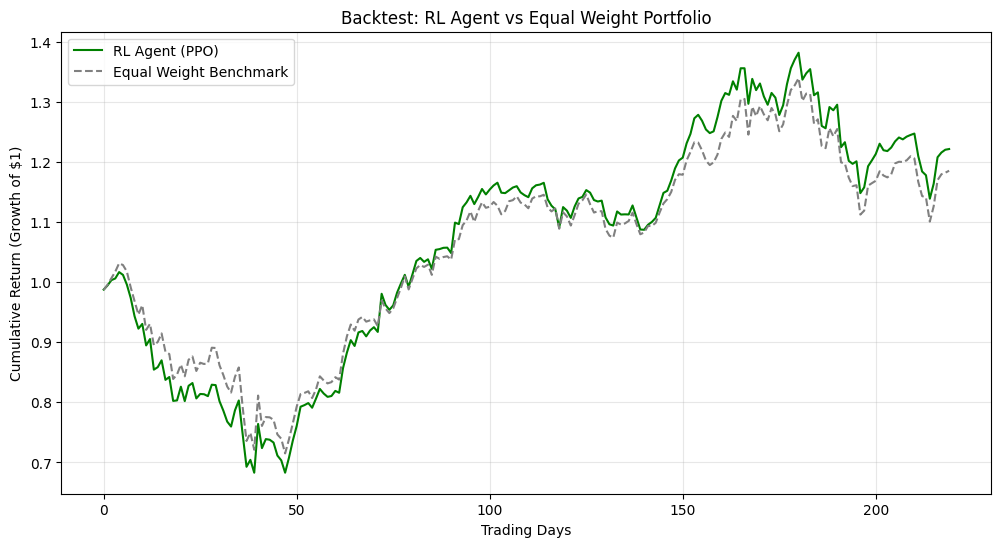

Final AI Portfolio Value: $1.22
Final Benchmark Value:    $1.19


In [13]:
test_env = PortfolioEnv(test_data)
obs, _ = test_env.reset()
done = False

rl_cumulative_returns = []
benchmark_cumulative_returns = []
portfolio_value = 1.0  
benchmark_value = 1.0

print("Running Backtest...")

while not done:
    action, _ = model.predict(obs)
    
    # Calculate performance manually for plotting
    ai_weights = test_env.softmax(action)
    
    current_step_idx = test_env.current_step
    if current_step_idx >= len(test_data):
        break
        
    next_day_ret = test_data.iloc[current_step_idx].values
    
    # Calculate returns
    ai_daily_ret = np.sum(ai_weights * next_day_ret)
    bench_daily_ret = np.mean(next_day_ret)
    
    portfolio_value *= (1 + ai_daily_ret)
    benchmark_value *= (1 + bench_daily_ret)
    
    rl_cumulative_returns.append(portfolio_value)
    benchmark_cumulative_returns.append(benchmark_value)
    
    obs, reward, done, truncated, info = test_env.step(action)

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(rl_cumulative_returns, label='RL Agent (PPO)', color='green')
plt.plot(benchmark_cumulative_returns, label='Equal Weight Benchmark', color='gray', linestyle='--')
plt.title('Backtest: RL Agent vs Equal Weight Portfolio')
plt.xlabel('Trading Days')
plt.ylabel('Cumulative Return (Growth of $1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final AI Portfolio Value: ${portfolio_value:.2f}")
print(f"Final Benchmark Value:    ${benchmark_value:.2f}")

------------------------------------------------
  🤖 AI RECOMMENDED PORTFOLIO FOR 2025-12-28  
------------------------------------------------
   Ticker    Weight
16   NVDA  0.126490
1    SOFI  0.126490
5      ZS  0.126490
15  GOOGL  0.105865
13    VOO  0.104721
6    SMCI  0.098366
10   AAPL  0.057779
11   META  0.052961
8    AMZN  0.049408
3    MSFT  0.026739
4     NVO  0.018472
12    AMD  0.018433
7    CRWV  0.018275
2    AIPO  0.018156
9      MU  0.017119
14    TSM  0.017119
0    BBAI  0.017119


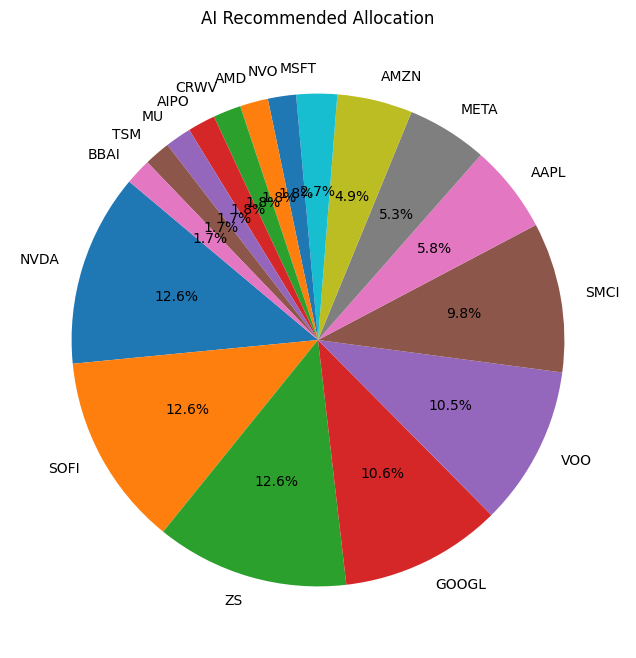

In [14]:
# 1. Get the very latest window of data (Last 30 days)
# We use the full dataset 'log_returns' to ensure we have the most recent days.
last_30_days = log_returns.iloc[-30:].values

# 2. Ask the AI what to do
# We need to reshape the data to match what the model expects (1, 30, N)
obs = last_30_days.reshape(1, 30, len(tickers))
action, _ = model.predict(obs)

# 3. Convert abstract action into readable weights
# We use the same softmax helper from the environment
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

weights = softmax(action[0])

# 4. Create a Readable "Buy List"
portfolio_allocation = pd.DataFrame({
    'Ticker': tickers,
    'Weight': weights
})

# Filter out tiny weights (less than 1%) to reduce noise
portfolio_allocation = portfolio_allocation[portfolio_allocation['Weight'] > 0.01]

# Sort by biggest holdings
portfolio_allocation = portfolio_allocation.sort_values(by='Weight', ascending=False)

# 5. Display the result
print("------------------------------------------------")
print(f"  🤖 AI RECOMMENDED PORTFOLIO FOR {datetime.today().date()}  ")
print("------------------------------------------------")
print(portfolio_allocation)

# Visual Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(portfolio_allocation['Weight'], labels=portfolio_allocation['Ticker'], autopct='%1.1f%%', startangle=140)
plt.title("AI Recommended Allocation")
plt.show()